# Practise Segmentation

## Dataset

We'll use the Oxford-IIIT Pet Dataset. It consists of 37 classes of dogs and cats, with about 200 images per class. The dataset contains both boxes and masks. There are approximately 7,000 images in the dataset.

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Let's download and unpack data.

In [ ]:
# %%capture out
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
# !rm  images/*.mat

Note that we have two folders in the data. The first contains `images`, and the second contains masked images marked as `binary`.

## Import Libraries

In [2]:
!pip install albumentations torchmetrics pytorch_lightning -U

In [5]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

/Users/dmitriygolubitskiy/Library/Mobile Documents/com~apple~CloudDocs/Documents/Technology/Data Science/IDE2/DataCleaningProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
path_images = "data/images/"
path_masks = "data/annotations/trimaps/"

In [6]:
os.listdir()

['.DS_Store', 'Segmentation_practice2.ipynb', 'data']

## Data Preparation

Each pixel in the mask image can take one of three values: "1," "2," or "3." "1" means that the pixel belongs to the "animal" class, "2" to the "background" class, and "3" to the "border" class. Since this example demonstrates a binary segmentation task (that is, assigning one of two classes to each pixel), we'll preprocess the mask so it contains only two unique values: 0 if the pixel is background, and 1 if the pixel is an animal or a border.

In [7]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [9]:
class PetDataset(Dataset):
    def __init__(self, split="train", transform=None):
        images_train, images_test = train_test_split(
            os.listdir(path_images), random_state=142, shuffle=True, train_size=0.8
        )
        if split == "train":
            self.images_filenames = images_train
        else:
            self.images_filenames = images_test

        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(path_images, image_filename))
        if image is None:
            return self.__getitem__(idx + 1 if self.__len__() > idx + 1 else 0)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(
                path_masks, image_filename.replace(".jpg", ".png")
            ),
            cv2.IMREAD_UNCHANGED,
        )
        if mask is None:
            return self.__getitem__(idx + 1 if self.__len__() > idx + 1 else 0)

        mask = preprocess_mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [10]:
train_dataset = PetDataset()
val_dataset = PetDataset(split="val")

### Визуализация для проверки себя, аугментаций, данных

In [ ]:
def display_few_examples_from_data(dataset, n=4):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 24))
    for i in range(n):
        image, mask = dataset.__getitem__(i)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

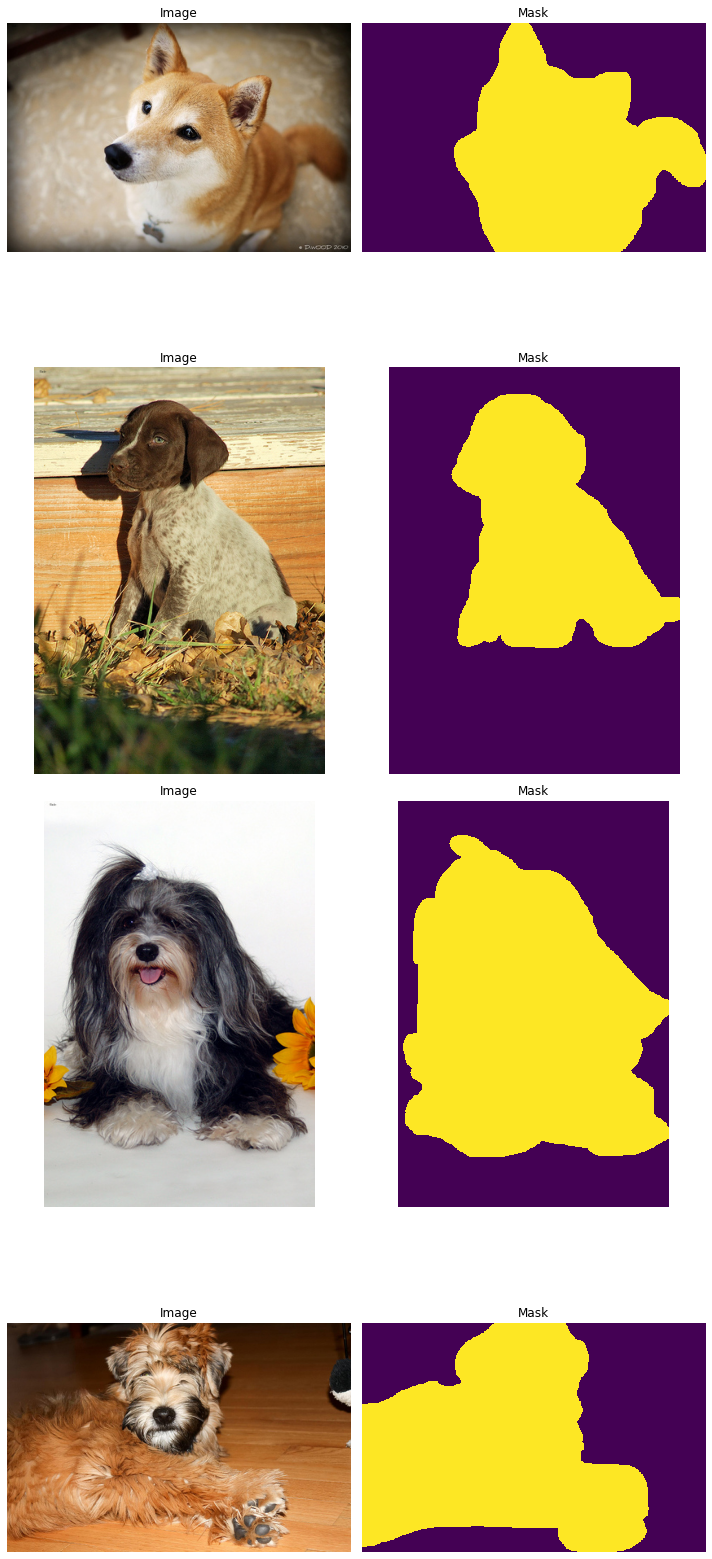

Validation dataset


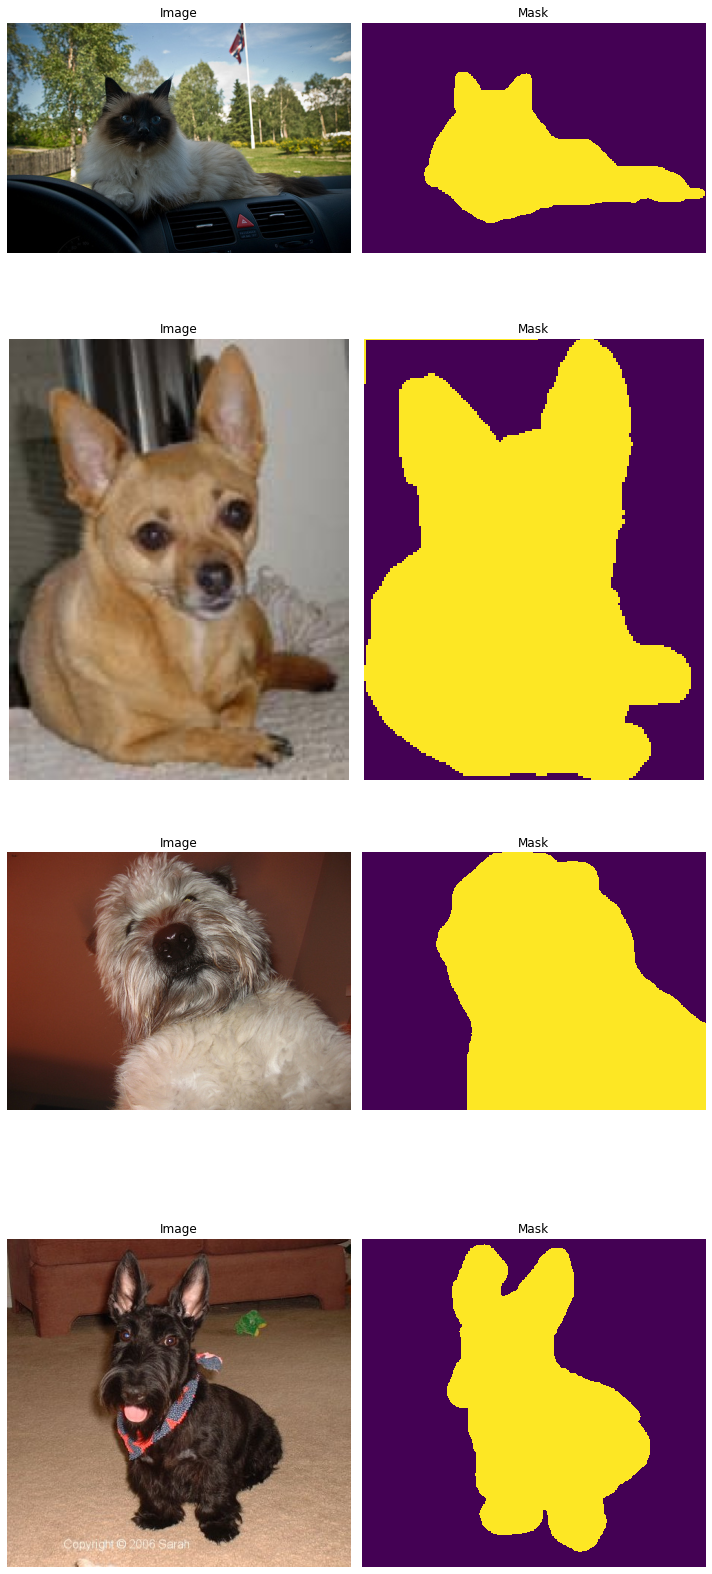

In [ ]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

### Выбираем аугментации для обучения

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # ToTensorV2(),
    ]
)
train_dataset = PetDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512)
        # Заполни своими
    ]  # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = PetDataset("Val", transform=train_transform)

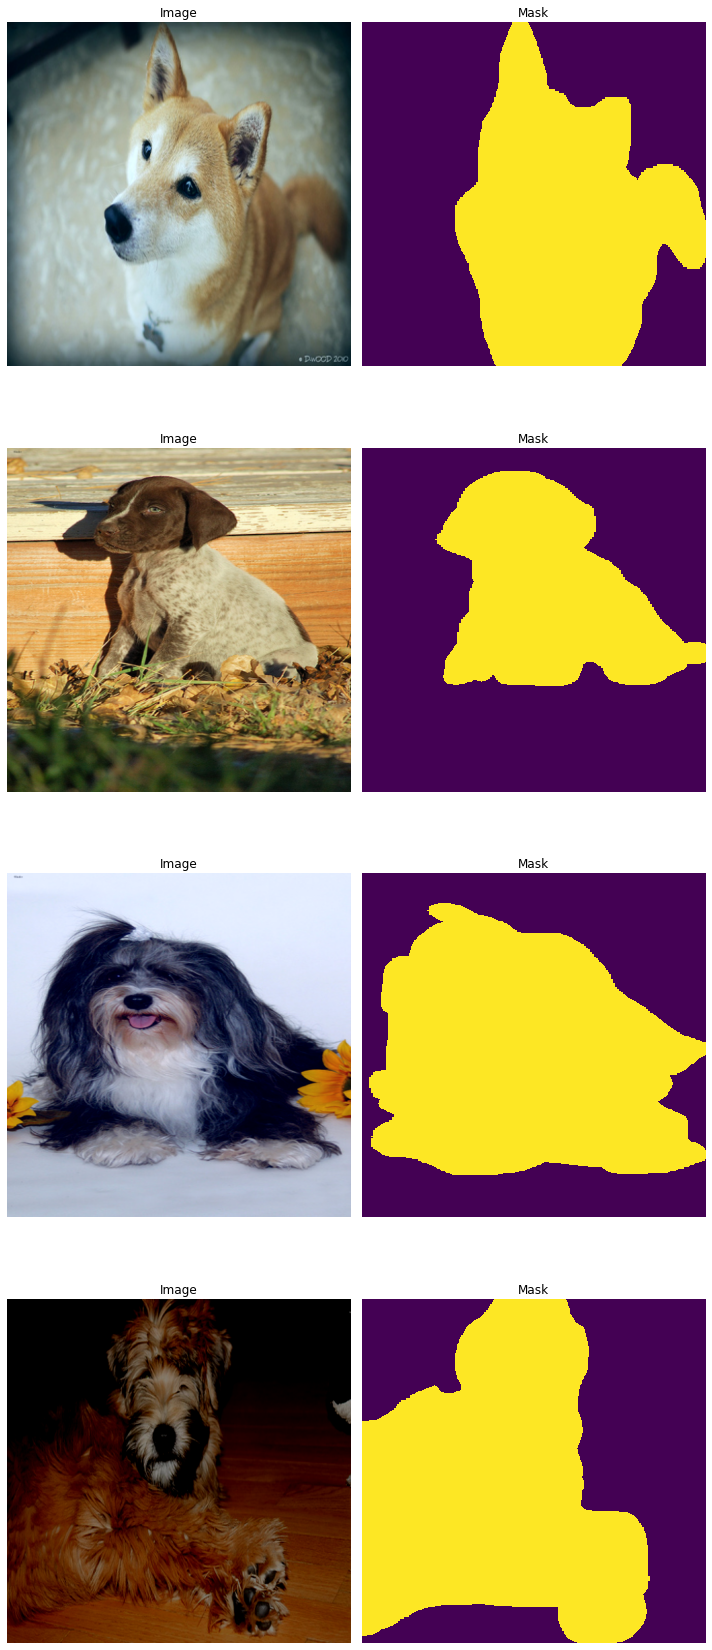

Validation dataset


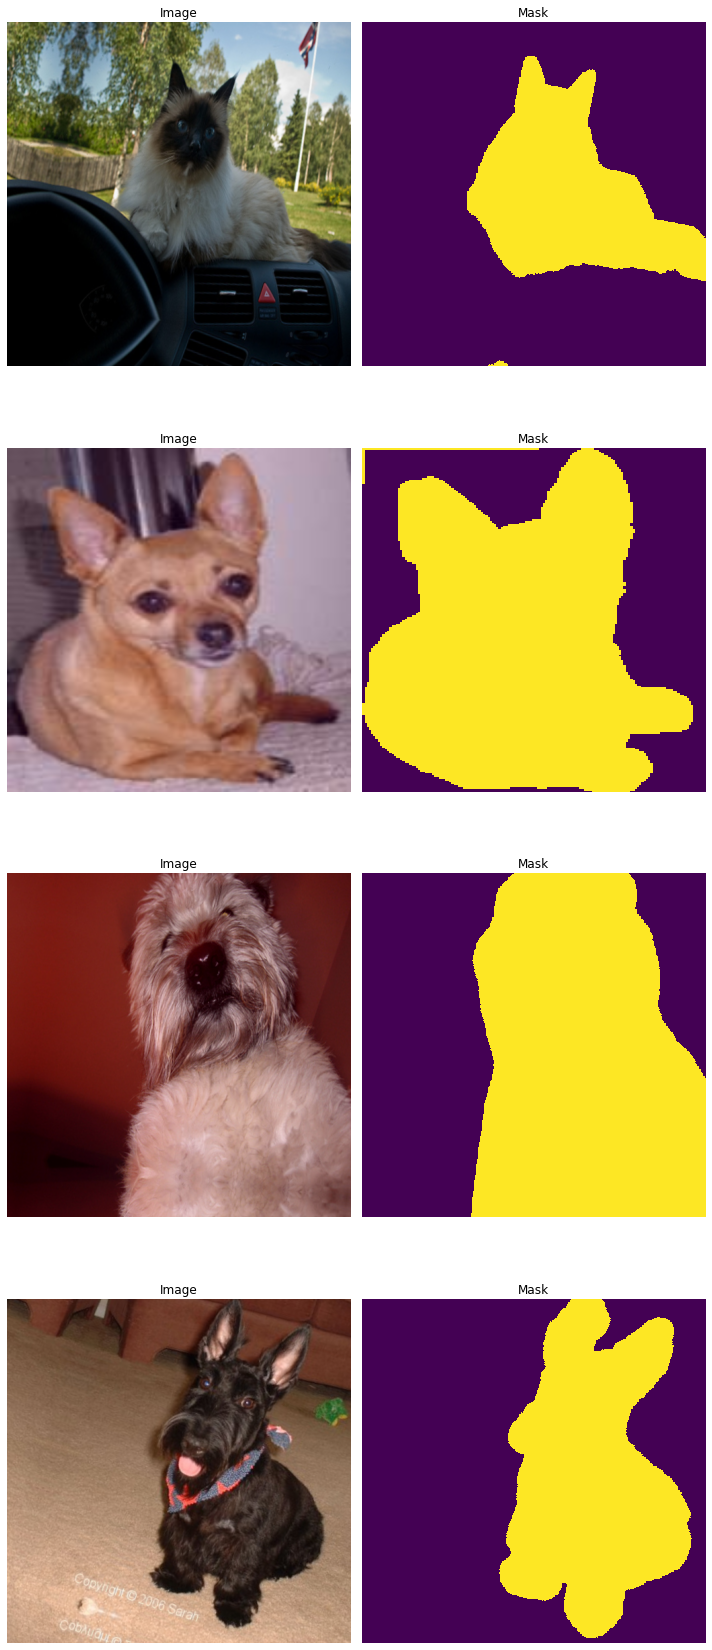

In [ ]:
display_few_examples_from_data(train_dataset)
print("Validation dataset")
display_few_examples_from_data(val_dataset)

### После выбора аугментаций создаем датасеты для обучения.

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = PetDataset(
    "train",
    transform=train_transform,
)

val_transform = A.Compose(
    [
        A.Resize(512, 512),
     # Заполни своими
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = PetDataset("Val", transform=train_transform)

## Модель и обучение

In [ ]:
def IoU(preds, targs, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou

In [ ]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = 8
        self.learning_rate = 1e-4
        self.net = SomeModel(n_classes=1)

        self.trainset = train_dataset
        self.valset = val_dataset
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self.forward(img) # [B, 1, H, W]
        loss_val = self.criterion(out.squeeze(1), mask) # [B, 1, H, W] -> # [B, H, W]
        iou_score = IoU(out.float(), mask.long())
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset, 
                          batch_size=self.batch_size, 
                          shuffle=True, prefetch_factor=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=True)

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)
        loss_val = self.criterion(out.squeeze(1), mask)
        iou_score = IoU(out.float(), mask.long())
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)

### Обучение

In [ ]:
model = SegModel(train_dataset, val_dataset)

trainer = pl.Trainer(
    gpus=1,
    # tpu_cores=1,
    max_epochs=500,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  # Log learning rate every epoch
    progress_bar_refresh_rate=1,
)

trainer.fit(model)

### Валидация.
Результат ожидается тут.

In [ ]:
trainer.validate(model, 
                 ckpt_path="lightning_logs/version_/checkpoints/*.ckpt", 
                 val_dataloaders=model.val_dataloader())